# Entrenar modelos de YOLO en Google Colab

Este notebook usa la librería de [Ultralytics](https://docs.ultralytics.com/) para entrenar modelos de YOLO para nuestro sistema de detección de objetos con el dataset que hemos recogido. En este caso, entrenamos con el dataset de exterior para cámara térmica.
Google Colab funciona como una máquina virtual de Linux y tiene acceso a una GPU gratuita. Tendremos que instalar las librerías de PyTorch y Ultralytics en el entorno para poder usarlas en el entrenamiento de nuestros modelos.






**Comprobar acceso a la GPU de NVIDIA**

Hay que elegir la GPU Tesla T4 con los botones: "Runtime" -> "Change runtime type". La siguiente instrucción verifica que se tiene acceso a la GPU y que se puede usar para entrenar.

In [ ]:
!nvidia-smi

Fri May 23 16:47:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# 1.&nbsp;Subir Dataset a Google Colab

Tenemos que subir nuestra carpeta a Google Colab con los datos que hemos recopilado, que se puede hacer simplemente desde el menú lateral. Para ello, debemos hacerlo en formato ZIP y este deben contener lo siguiente: 
* **Archivo classes.txt:** Archivo de texto (formato .txt) que contenga las clases que el modelo debe ser capaz de detectar. 
* **Carpeta images:** Carpeta con todas las imágenes (en cualquier formato: .jpg, .png, ...) con las que se busca entrenar el modelo de YOLO. 
* **Carpeta labels:** Carpeta con los archivos de etiquetas de cada una de las imágenes. Deben tener el mismo nombre que la imagen a la que acompañan, tener extensión .txt y estar codificados en formato YOLO. 

## 2 Separar datos en entrenamiento y validación

El primer paso es descomprimir el ZIP que hemos subido a Google Drive. Hemos dejado el nombre de la carpeta que usamos para los datos de interior con cámara RGB.

In [ ]:
# Unzip images to a custom data folder
!unzip -q /content/data_fotos_coche_term.zip -d /content/custom_data

Para poder entrenar utilizando las funciones de entrenamiento y validación de Ultralytics, se requiere que los datos estén organizados de una manera especial requires a particular folder structure to store training data for models. Es importante que todo esté contenido en una carpeta que se llame "data" y que, a su vez, contenga las siguientes carpetas: 

*   **Train**: Aquí se guardan las imágenes que van a ser utilizadas para entrenar nuestro modelo de YOLO. En cada época de entrenamiento se realiza un barrido completo por todas las imágenes de esta carpeta, para que el modelo pueda ajustar sus pesos en función de cada una de ellas. Esta carpeta debe contener un número suficiente de imágenes para que el modelo pueda aprender a generalizar correctamente, pero se debe garantizar que sean lo suficientemente diferentes y variadas para evitar el sobreajuste. 


*   **Validation**: Aqúi se almacen las imágenes que se usan para comprobar el rendimiento de los modelos tras cada época de entrenamiento. Con ellas podemos obtener medidas de precisión, recall y mAP en cada étapa del entrenamiento.

En cada una de estas carpetas, tenemos subdirectorios para las imágenes y para las anotaciones, exactamente igual que antes.

Para separar nuestros datos en las carpetas de entrenamiento y validación de manera apropiada, utilizamos un script de Python desarrollado por Edje Electronics. Se ha fijado destinar el 90% de las imágenes a entrenar y el 10% a validar, pero esto se puede ajustar cambiando el valor de train_pct en la siguiente celda. 

In [ ]:
!wget -O /content/train_val_split.py https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/utils/train_val_split.py

# TO DO: Improve robustness of train_val_split.py script so it can handle nested data folders, etc
!python train_val_split.py --datapath="/content/custom_data" --train_pct=0.9

--2025-05-23 16:53:38--  https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/utils/train_val_split.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3203 (3.1K) [text/plain]
Saving to: ‘/content/train_val_split.py’

/content/train_val_ 100%[===================>]   3.13K  --.-KB/s    in 0s      

2025-05-23 16:53:38 (84.4 MB/s) - ‘/content/train_val_split.py’ saved [3203/3203]

Created folder at /content/data/train/images.
Created folder at /content/data/train/labels.
Created folder at /content/data/validation/images.
Created folder at /content/data/validation/labels.
Number of image files: 827
Number of annotation files: 832
Images moving to train: 744
Images moving to validation: 83


# 3.&nbsp;Instalar Ultralytics

Instalar Ultralytics es indispensable para entrenar nuestros modelos YOLO. Se puede hacer de manera sencilla usando PIP de la siguiente manera: 

In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

# 4.&nbsp;Configurar el entrenamiento


Para poder comenzar el entrenamiento de nuestros modelos de YOLO, es necesario crear un archivo de configuración de tipo YAML en el que se especifiquen las clases presentes en el dataset (las escritas en nuestro archivo classes.txt) y la ubicación exacta de las carpetas con las imágenes de entrenamiento y validación.

In [ ]:
# Python function to automatically create data.yaml config file
# 1. Reads "classes.txt" file to get list of class names
# 2. Creates data dictionary with correct paths to folders, number of classes, and names of classes
# 3. Writes data in YAML format to data.yaml

import yaml
import os

def create_data_yaml(path_to_classes_txt, path_to_data_yaml):

  # Read class.txt to get class names
  if not os.path.exists(path_to_classes_txt):
    print(f'classes.txt file not found! Please create a classes.txt labelmap and move it to {path_to_classes_txt}')
    return
  with open(path_to_classes_txt, 'r') as f:
    classes = []
    for line in f.readlines():
      if len(line.strip()) == 0: continue
      classes.append(line.strip())
  number_of_classes = len(classes)

  # Create data dictionary
  data = {
      'path': '/content/data',
      'train': 'train/images',
      'val': 'validation/images',
      'nc': number_of_classes,
      'names': classes
  }

  # Write data to YAML file
  with open(path_to_data_yaml, 'w') as f:
    yaml.dump(data, f, sort_keys=False)
  print(f'Created config file at {path_to_data_yaml}')

  return

# Define path to classes.txt and run function
path_to_classes_txt = '/content/custom_data/classes.txt'
path_to_data_yaml = '/content/data.yaml'

create_data_yaml(path_to_classes_txt, path_to_data_yaml)

print('\nFile contents:\n')
!cat /content/data.yaml

Created config file at /content/data.yaml

File contents:

path: /content/data
train: train/images
val: validation/images
nc: 2
names:
- person
- car


# 5.&nbsp;Entrenar el modelo YOLO

## 5.1 Especificar parámetros de entrenamiento
Una vez creado el archivo de configuración del entrenamiento, solo queda configurar los parámetros antes de poder entrenar el modelod e YOLO.

**Arquitectura de YOLO a entrenar (`model`):**

EL modelo elegido para utilizar en este sistema es YOLOv8n debido a su combinación de alta precisión y bajos recursos para funcionar No obstante se puede cambiar a otra arquitectura de la famila YOLOv8 o una más moderna como YOLOv11 simplemente eligiendo otro modelo en el parámetro `model`. 

**Número de épocas (`epochs`)**

Una época (o “epoch” en inglés) es una pasada completa por todo el dataset de entrenamiento, que permite que el modelo vaya ajustando sus pesos para predecir correctamente imágenes similares. Es importante elegir un número adecuado de épocas con las que entrenar porque está directamente relacionado con el tiempo total de entrenamiento. Quedarnos cortos implicaría que el modelo esté subajustado y que no sea capaz de predecir correctamente los objetos presentes en cada escena, pero si nos pasamos se corre el riesgo de llegar al sobreajuste, en el que el modelo pierde la capacidad de generalización y no podrá precedir imágenes distintas del conjunto de entrenamiento. Con prueba y error, hemos visto que es adecuado entrenar nuestro modelo YOLO con nuestro dataset de imágenes con 60 épocas, lo que se traduce en aproximadamente una hora. 

No obstante, se puede modificar la cantidad de épocas para entrenar editando el valor de `epochs` de la siguiente instrucción.


**Resolución de las imágenes (`imgsz`)**

La resolución de las imágenes tiene un impacto importante en la velocidad y la precisión del modelo.
    - A menor resolución, más rápido será el modelo a la hora de predecir, aunque probablemente la precisión se vea afectada negativamente. 
    - A mayor resolución, más lento será el modelo, pero la precisión será mejor. 
    
Los modelos de YOLO se suelen entrenar para funcionar con imágenes de resolución 640x640. Pero si el modelo es demasiado lento o las cámaras utilizadas son de mala calidad, es común reducirla a 480x480. Para nuestro sistema hemos dejado la opción por defecto, pero se puede modificar a través del parámetro `imgsz`.


## 5.2 Proceso de entrenamiento

Para entrenar nuestro modelo de YOLO basta con ejecutar la siguiente celda. Ultralytics comenzará descargando la arquitectura del modelo desde su página web y abriendo la carpeta de Train y de Validation para acceder a las imágenes y a sus etiquetas. 

In [ ]:
!yolo detect train data=/content/data.yaml model=yolov8n.pt epochs=60 imgsz=640

100% 6.25M/6.25M [00:00<00:00, 319MB/s]
Ultralytics 8.3.143 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, pl

Para cada época de entrenamiento, se ejecuta el modelo con el dataset de validación, lo que permite obtener métricas para mAP, precisión y para recall. Conforme avance el entrenamiento se espera que mAP incremente su valor en cada época, hasta alcanzar el máximo especificado por el parámetro `epochs`. Es importante asegurarnos de que el entrenamiento se termine porque Ultralytics aplica un optimizador que elimina parámetros o capas que no hagan falta, mejorando así el rendimiento general del modelo.

Al finalizar, el mejor modelo entrenado se guarda en la carpeta `content/runs/detect/train/weights/best.pt` y las gráficas y medidas de validación generadas se meten en `content/runs/detect/train` folder. 

# 6.&nbsp;Probar el modelo

Una vez finalizado el entrenamiento, podemos probar si clasifica correctamente usando el conjunto de imágenes de validación. COn el siguiente comando, podemos probar qué ha detectado en ellas y mostrar por pantalla las diez primeras con sus bounding boxes graficadas sobre ellas.

In [ ]:
!yolo detect predict model=runs/detect/train2/weights/best.pt source=data/validation/images save=True

Ultralytics 8.3.143 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs

image 1/59 /content/data/validation/images/image_coche1_temp230.jpg: 512x640 3 cars, 37.6ms
image 2/59 /content/data/validation/images/image_coche1_temp459.jpg: 512x640 1 car, 6.5ms
image 3/59 /content/data/validation/images/image_coche1_temp607.jpg: 512x640 1 person, 3 cars, 6.4ms
image 4/59 /content/data/validation/images/image_coche1_temp670.jpg: 512x640 2 cars, 6.1ms
image 5/59 /content/data/validation/images/image_coche1_temp799.jpg: 512x640 10 cars, 6.1ms
image 6/59 /content/data/validation/images/image_coche1_temp806.jpg: 512x640 4 cars, 6.1ms
image 7/59 /content/data/validation/images/image_coche1_temp952.jpg: 512x640 1 person, 1 car, 6.2ms
image 8/59 /content/data/validation/images/image_coche2_temp268.jpg: 512x640 2 persons, 2 cars, 6.2ms
image 9/59 /content/data/validation/images/image_coche2_temp474.jpg: 512x640 

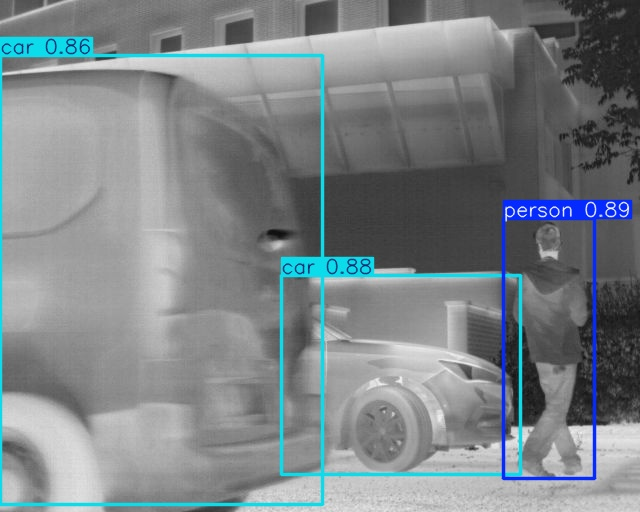

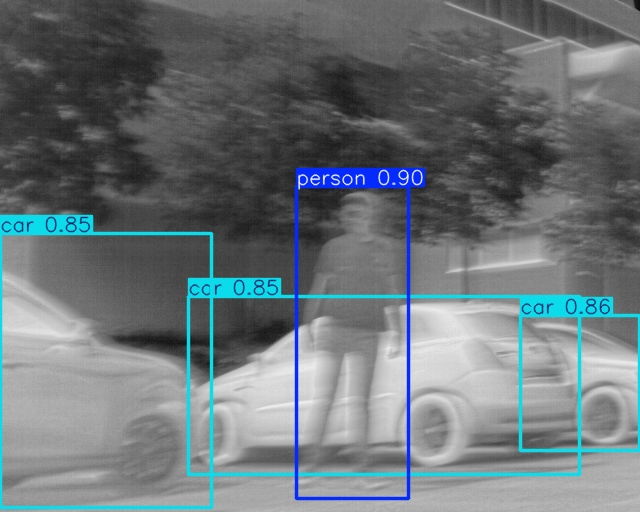

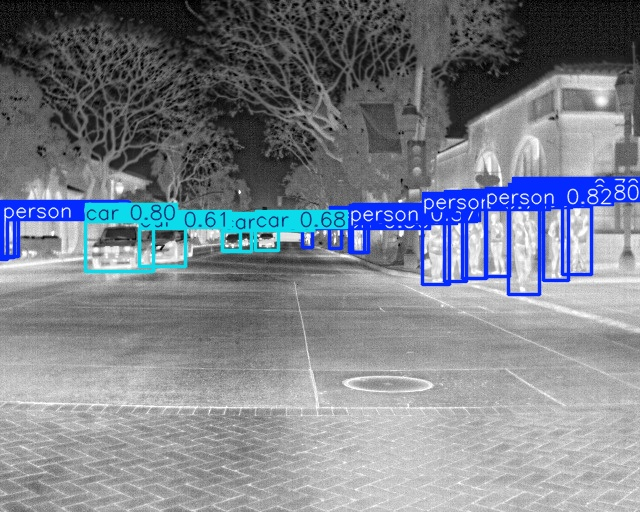

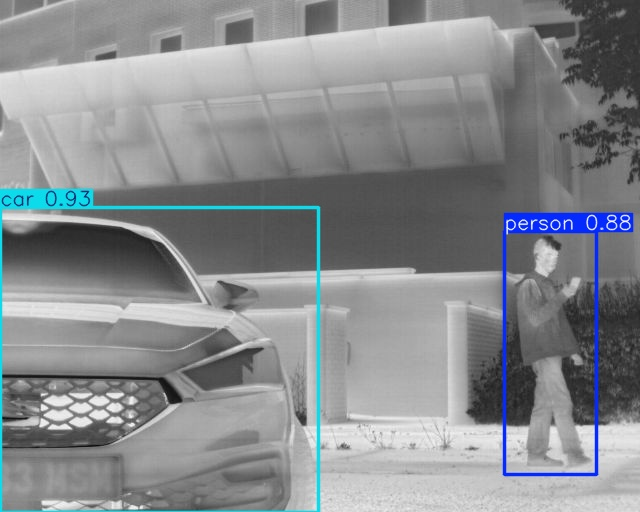

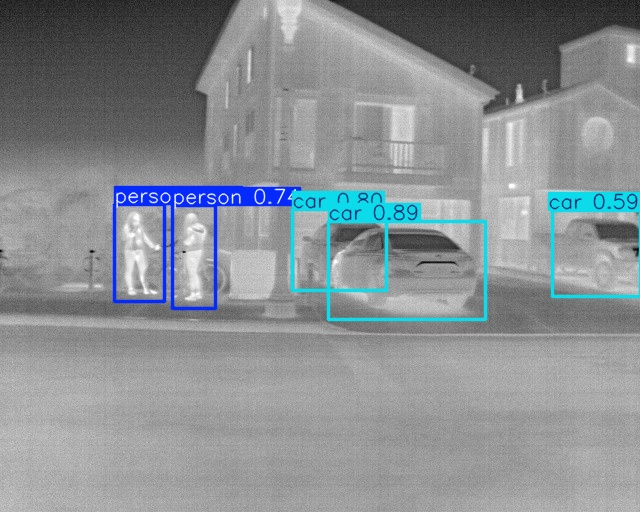

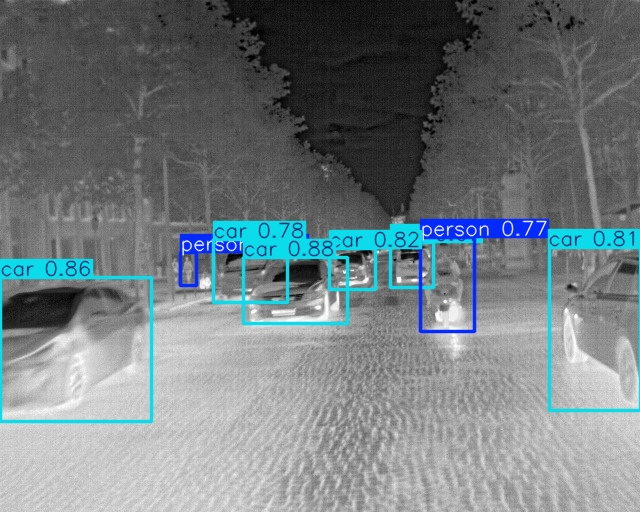

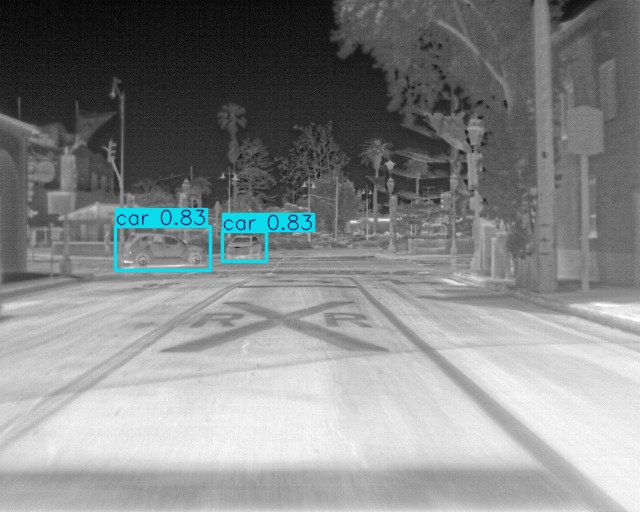

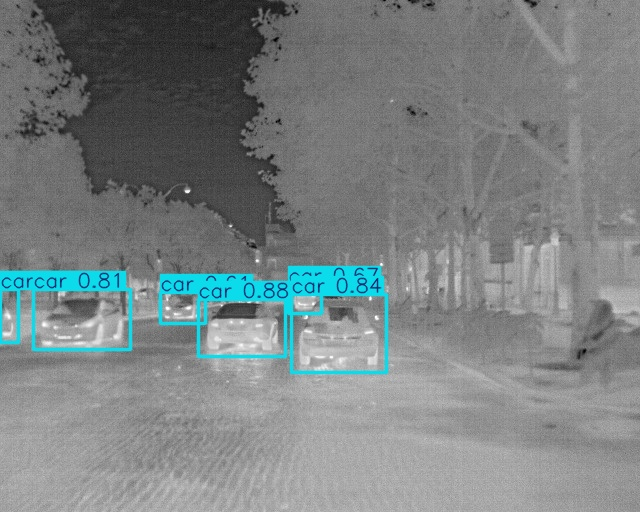

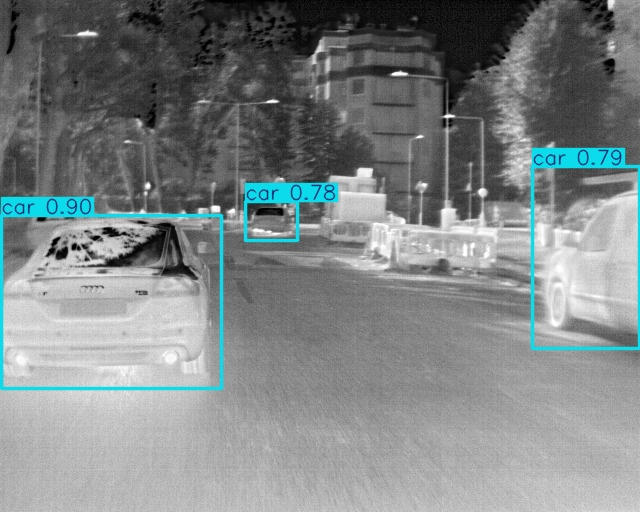

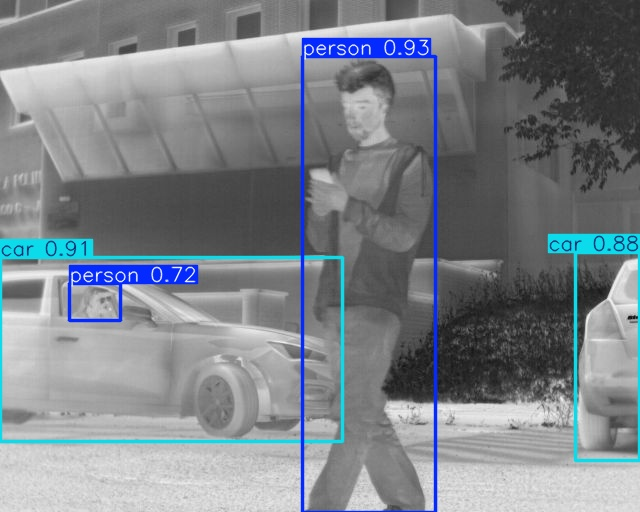

In [ ]:
import glob
from IPython.display import Image, display
for image_path in glob.glob(f'/content/runs/detect/predict/*.jpg')[:10]:
  display(Image(filename=image_path, height=400))
  print('\n')


## 7 Descargar el modelo YOLO
Para poder usar el modelo YOLO fuera de Google Colab es importante descargarlo. Además, cuando se cierre la sesión de Colab todo el almacenamiento es borrado y para obtener el modelo de nuevo sería necesario volverlo a entrenar de cero. 

Para descargarlo, con las siguientes celdas podemos hacer una carpeta con el modelo (guardado como archivo .pt de Pytorch) y sus salidas gráficas de validación y después comprimirlo en ZIP y descargarlo desde la pestaña de descargas de nuestro navegador.

In [ ]:
# Create "my_model" folder to store model weights and train results
!mkdir /content/my_model
!cp /content/runs/detect/train2/weights/best.pt /content/my_model/my_model.pt
!cp -r /content/runs/detect/train2 /content/my_model

# Zip into "my_model.zip"
%cd my_model
!zip /content/my_model.zip my_model.pt
!zip -r /content/my_model.zip train2
%cd /content

/content/my_model
  adding: my_model.pt (deflated 9%)
  adding: train2/ (stored 0%)
  adding: train2/train_batch1651.jpg (deflated 10%)
  adding: train2/confusion_matrix.png (deflated 33%)
  adding: train2/train_batch1650.jpg (deflated 8%)
  adding: train2/args.yaml (deflated 53%)
  adding: train2/results.png (deflated 7%)
  adding: train2/F1_curve.png (deflated 10%)
  adding: train2/val_batch0_pred.jpg (deflated 9%)
  adding: train2/confusion_matrix_normalized.png (deflated 32%)
  adding: train2/train_batch2.jpg (deflated 3%)
  adding: train2/val_batch1_labels.jpg (deflated 7%)
  adding: train2/weights/ (stored 0%)
  adding: train2/weights/best.pt (deflated 9%)
  adding: train2/weights/last.pt (deflated 9%)
  adding: train2/train_batch0.jpg (deflated 4%)
  adding: train2/labels_correlogram.jpg (deflated 38%)
  adding: train2/R_curve.png (deflated 11%)
  adding: train2/val_batch1_pred.jpg (deflated 7%)
  adding: train2/train_batch1.jpg (deflated 5%)
  adding: train2/results.csv (deflat

In [9]:
# This takes forever for some reason, you can also just download the model from the sidebar
from google.colab import files

files.download('/content/my_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>